In [1]:
# import relevant libraries
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

# import libraries relevant to plotting (t-SNE)
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## Minimizing Objective Function for SGNS

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [2]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))


In [3]:
# define function to get embedding vectors
def get_embedding_vectors(target, context, V, U):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    V: matrix of dim (n x |v|)
    U: matrix of dim (|v| x n)
        n = embedding dimension, |v| = vocab size

    Output
    v_t: target word vector, dimension: (n,)
    u_c: context word vectors, consists of u_pos and u_neg: dimension: (n, len(context))
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = U[context]
    return v_t, u_c

# t = targets[0]
# c = contexts[0]
# v_test, u_test = get_embedding_vectors(t, c, V, U)
# print(f'v_test shape: {v_test.shape}')
# print(f'u_test shape: {u_test.shape}')

In [4]:
# define local_loss function
@jax.jit
def local_loss(params):
    """
    Input (example)
    params = [v_t, jnp.array([u_pos, u_neg])]
        v_t: target word vector, dimension: (n,)
        u_c: context word vectors, consists of u_pos and u_neg: dimension: (len(context), n)

    Output
    local_loss: real number
    """
    v_t = params[0]
    u_c = params[1]
    return -jnp.log(sigmoid(jnp.dot(u_c[0], v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_c[1:], v_t))))

# p = [V[:, 0], U[:5, :]]
# print(f'local_loss: {local_loss(p)}')


In [5]:
# define gradient function
L_grad = jax.grad(local_loss)

In [6]:
# function to evaluate the model performance over each epoch
def predict_proba(target, context, V):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target] # dimensions: (batch_size, n)
    u_c = V.T[context] # dimensions: (batch_size, n)
    return sigmoid(np.sum(v_t * u_c, axis=1)) # dimensions: (batch_size,)

# define a predict function
def predict(target, context, V, threshold=0.5):
    """
    Input
    target: vector of shape (batch_size,) --> target word indices
    context: vector of shape (batch_size,) --> context word indices
    V: matrix of shape (n, |v|) --> word embedding matrix
    threshold: real number --> threshold value for the sigmoid function

    Output
    predicted: vector of shape (batch_size,) --> predicted values
    """
    target = target.astype(int)
    context = context.astype(int)
    v_t = V.T[target]
    u_c = V.T[context]
    return np.where(sigmoid(np.sum(v_t * u_c, axis=1)) > threshold, 1, 0)

# define a function that calculates the MSE between predicted and actual values
def mse(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values (probabilities summing to 1)
    actual: vector of shape (batch_size,) --> actual values

    Output
    mse: real number --> mean squared error
    """
    return np.mean((predicted - actual) ** 2)

# define a function that calculates the accuracy between predicted and actual values
def accuracy_score(predicted, actual):
    """
    Input
    predicted: vector of shape (batch_size,) --> predicted values (0 or 1)
    actual: vector of shape (batch_size,) --> actual values

    Output
    accuracy: real number --> accuracy score
    """
    return np.mean(predicted == actual)

In [21]:
# define a function that evaluates the model over accuracy and mse
def evaluate_model(V, targets, contexts, labels, num_samples=500):
    """
    Input
    V: matrix of shape (n, |v|) --> word embedding matrix
    targets: matrix of shape (batch_size,) --> target word indices
    contexts: matrix of shape (batch_size,) --> context word indices
    labels: matrix of shape (batch_size,) --> actual values

    Output
    mse_score: real number --> mean squared error
    accuracy: real number --> accuracy score
    """
    # randomly select 1000 samples from data
    # 500 indices are for positive data, 500 for negative data
    indices = np.random.choice(len(targets), num_samples, replace=False)
    # split these indices into half, 500 for positive data, 500 for negative data
    indices_pos = indices[:num_samples//2]
    indices_neg = indices[num_samples//2:]

    targets_random_pos = targets[indices_pos]
    contexts_random_pos = contexts[indices_pos, 0]
    labels_random_pos = labels[indices_pos, 0]

    # generate negative samples and shuffle the contexts[indices_neg, 1] up
    targets_random_neg = targets[indices_neg]
    # shuffle the contexts[indices_neg, 1] up
    contexts_random_neg = contexts[indices_neg, 1]
    contexts_random_neg = np.random.permutation(contexts_random_neg)
    labels_random_neg = labels[indices_neg, 1]

    # combine positive and negative samples, dimensions: (1000,)
    targets_random = np.concatenate((targets_random_pos, targets_random_neg))
    contexts_random = np.concatenate((contexts_random_pos, contexts_random_neg))
    labels_random = np.concatenate((labels_random_pos, labels_random_neg))

    # calculate accuracy
    predicted_binary = predict(targets_random, contexts_random, V)
    accuracy = accuracy_score(predicted_binary, labels_random)

    # calculate mse
    predicted_proba = predict_proba(targets_random, contexts_random, V)
    mse_score = mse(predicted_proba, labels_random)

    return mse_score, accuracy
    

In [81]:
# read in the processed data

# read .npy files from data/processed_data/train
# train
targets_train = np.load('./data/processed_data/train/num_ns_10/targets.npy')
contexts_train = np.load('./data/processed_data/train/num_ns_10/contexts.npy')
lables_train = np.load('./data/processed_data/train/num_ns_10/labels.npy')

# test
targets_test = np.load('./data/processed_data/test/num_ns_10/targets.npy')
contexts_test = np.load('./data/processed_data/test/num_ns_10/contexts.npy')
lables_test = np.load('./data/processed_data/test/num_ns_10/labels.npy')

# read vocab and inverse vocab json files
import json
with open('./data/processed_data/vocab_train.json') as f:
    vocab_train = json.load(f)

with open('./data/processed_data/inverse_vocab_train.json') as f:
    inverse_vocab_train = json.load(f)

# import vocab_test and inverse_vocab_test
with open('./data/processed_data/vocab_test.json') as f:
    vocab_test = json.load(f)

with open('./data/processed_data/inverse_vocab_test.json') as f:
    inverse_vocab_test = json.load(f)

# print shapes of all the variables
print(f"targets_train shape: {targets_train.shape}")
print(f"contexts_train shape: {contexts_train.shape}")
print(f"lables_train shape: {lables_train.shape}")

print(f"targets_test shape: {targets_test.shape}")
print(f"contexts_test shape: {contexts_test.shape}")
print(f"lables_test shape: {lables_test.shape}")

print(f"vocab_train: {len(vocab_train)}")
print(f"inverse_vocab_train: {len(inverse_vocab_train)}")

print(f"vocab_test: {len(vocab_test)}")
print(f"inverse_vocab_test: {len(inverse_vocab_test)}")

targets_train shape: (226197,)
contexts_train shape: (226197, 11)
lables_train shape: (226197, 11)
targets_test shape: (16780,)
contexts_test shape: (16780, 11)
lables_test shape: (16780, 11)
vocab_train: 14119
inverse_vocab_train: 14119
vocab_test: 3382
inverse_vocab_test: 3382


In [82]:
# set up
n = 300
v = len(vocab_train)
V_init = np.random.normal(0, 1, size=(n, v)) / np.sqrt(n)
U_init = np.random.normal(0, 1, size=(v, n)) / np.sqrt(n)

targets_data = targets_train.astype(float)
contexts_data = contexts_train.astype(float)
labels_data = lables_train.astype(float)

print(f'V shape: {V_init.shape}')
print(f'U shape: {U_init.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V shape: (300, 14119)
U shape: (14119, 300)
targets_data shape: (226197,)
contexts_data shape: (226197, 11)
labels_data shape: (226197, 11)


In [83]:
# train using (stochastic) gradient descent

# set up
V = V_init.copy()
U = U_init.copy()
params = [V, U]

N = len(targets_data)
n_epochs = 100

lr = 0.1

# results
epoch_losses = []
train_mses = []
train_accuracies = []
test_mses = []
test_accuracies = []

# gradient descent
for epoch in range(n_epochs):

    start_time = time.time()

    # shuffle data
    perm = np.random.permutation(N)
    targets_epoch = targets_data[perm]
    contexts_epoch = contexts_data[perm]
    labels_epoch = labels_data[perm]

    # reduce learning rate
    if epoch == 50 and epoch == 75:
        lr /= 2

    losses = []
    for i in range(2500):
        # stop after 2500 iterations
        target = targets_epoch[i].astype(int) 
        context = contexts_epoch[i].astype(int)
        label = labels_epoch[i].astype(int)

        # get the embedding vectors
        v_t, u_c = get_embedding_vectors(target, context, V, U)

        # get the loss value and gradient
        loss_value = local_loss([v_t, u_c])
        grad = L_grad([v_t, u_c])

        # update the parameters
        partial_V = grad[0]
        partial_U = grad[1]
        
        V[:, target] = V[:, target] - lr * partial_V
        U[context, :] = U[context, :] - lr * partial_U

        # store the loss value
        losses.append(loss_value)

    # calculate train and test mse and accuracy for num_samples = 1000 random samples
    train_mse, train_accuracy = evaluate_model(V, targets_train, contexts_train, lables_train)
    test_mse, test_accuracy = evaluate_model(V, targets_test, contexts_test, lables_test)

    # store results
    epoch_losses.append(np.mean(losses))
    train_mses.append(train_mse)
    train_accuracies.append(train_accuracy)
    test_mses.append(test_mse)
    test_accuracies.append(test_accuracy)
    
    end_time = time.time()
    
    # print epoch loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end_time - start_time:.2f}s")

Epoch 1/100 	 loss = 7.577062606811523 	 time = 9.69s
Epoch 11/100 	 loss = 5.66618013381958 	 time = 9.27s
Epoch 21/100 	 loss = 4.736334323883057 	 time = 8.67s
Epoch 31/100 	 loss = 4.208597183227539 	 time = 8.74s
Epoch 41/100 	 loss = 3.8609495162963867 	 time = 9.10s
Epoch 51/100 	 loss = 3.6140050888061523 	 time = 8.70s
Epoch 61/100 	 loss = 3.425523519515991 	 time = 8.51s
Epoch 71/100 	 loss = 3.2765915393829346 	 time = 8.52s
Epoch 81/100 	 loss = 3.1551096439361572 	 time = 8.91s
Epoch 91/100 	 loss = 3.0513453483581543 	 time = 8.27s


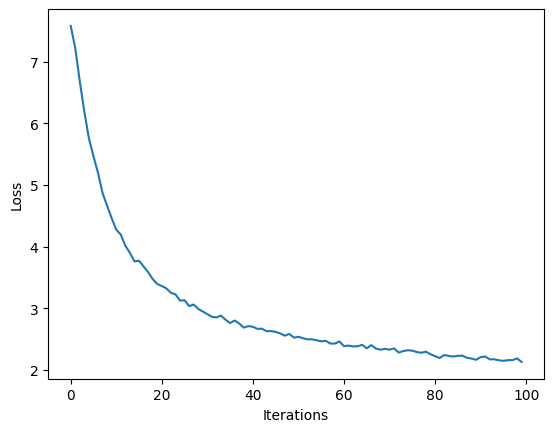

In [84]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

# save as .png file
plt.savefig('./results/sgns-partial/case5/losses.png')

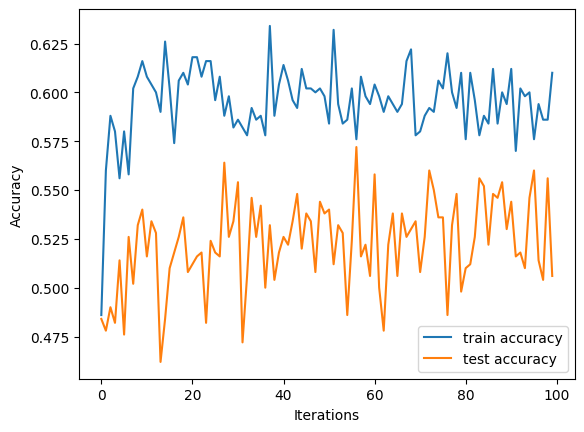

In [85]:
# plot training accuracy and test accuracy on the same plot
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

# save as .png file
plt.savefig('./results/sgns-partial/case5/accuracy.png')

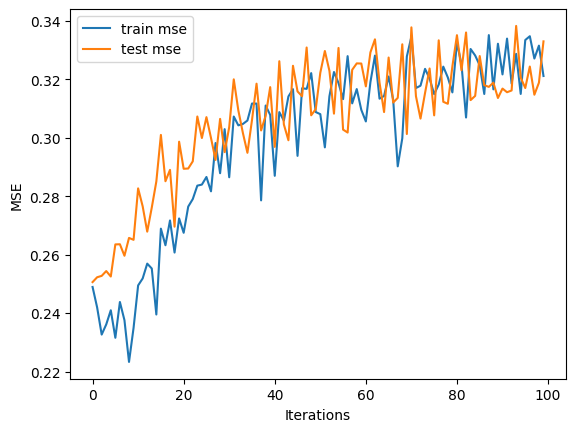

In [86]:
# plot training and test mse on the same plot
plt.plot(train_mses, label='train mse')
plt.plot(test_mses, label='test mse')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.legend()

# save as .png file
plt.savefig('./results/sgns-partial/case5/mse.png')

In [87]:
# copy U and V
V_trained = np.copy(params[0])
U_trained = np.copy(params[1])

print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 14119)
U_trained shape: (14119, 300)


#### Results

| Model Used | Num samples used | Num of Neg Samples | Train Accuracy | Test Accuracy | Train MSE | Test MSE |
|:-----------|:-----------------|:-------------------|:---------------|:--------------|:----------|:---------|
| Case 1 (updated) 29m08s | 0.5M - 100 epochs, 5,000 it/ep | 5 | 0.5836 | 0.5224 | 0.2844 | 0.2904 |
| Case 2 (updated) 31m04s | 0.5M - 100 epochs, 5,000 it/ep | 10 | 0.5684 | 0.4976 | 0.3269 | 0.3241 |
| Case 3 (updated) 29m57s| 0.5M - 100 epochs, 5,000 it/ep | 20 | 0.5806 | 0.5171 | 0.3510 | 0.3395 |
| Case 4 (updated) 15m8s | 0.25M - 100 epochs, 2,500 it/ep | 5 | 0.5804 | 0.5024 | 0.2710 | 0.2833 |
| Case 5 (updated) 14m49s | 0.25M - 100 epochs, 2,500 it/ep | 10 | 0.5980 | 0.5195 | 0.3232 | 0.3243 |
| Case 6 (updated) 14m50s | 0.25M - 100 epochs, 2,500 it/ep | 20 | 0.5986 | 0.5225 | 0.3548 | 0.3411 |

In [88]:
# evaluate the final model
# train accuracy and mse
train_mse, train_accuracy = evaluate_model(V_trained, targets_train, contexts_train, lables_train, num_samples=len(targets_train))
print(f'train mse: {train_mse:.4f}')
print(f'train accuracy: {train_accuracy:.4f}')

# test accuracy and mse
test_mse, test_accuracy = evaluate_model(V_trained, targets_test, contexts_test, lables_test, num_samples=len(targets_test))
print(f'test mse: {test_mse:.4f}')
print(f'test accuracy: {test_accuracy:.4f}')

train mse: 0.3232
train accuracy: 0.5980
test mse: 0.3243
test accuracy: 0.5195


In [89]:
# given epoch_losses, train_mses, train_accuracies, test_mses, test_accuracies
x = np.arange(n_epochs)
results = {'epoch': x, 'epoch_losses': epoch_losses, 'train_mses': train_mses, 'train_accuracies': train_accuracies, 'test_mses': test_mses, 'test_accuracies': test_accuracies}

In [90]:
# save all the results
# save V_trained, U_trained as csv files
np.savetxt('./results/sgns-partial/case5/V_trained.csv', V_trained, delimiter=',')
np.savetxt('./results/sgns-partial/case5/U_trained.csv', U_trained, delimiter=',')

# save results as csv file
results_df = pd.DataFrame(results)
results_df.to_csv('./results/sgns-partial/case5/results.csv', index=False)
results_df.head()

,epoch,epoch_losses,train_mses,train_accuracies,test_mses,test_accuracies
0,0,7.577063,0.24895003,0.486,0.25062037,0.484
1,1,7.217863,0.24194632,0.560,0.2522754,0.478
2,2,6.674710,0.23265179,0.588,0.2527511,0.490
3,3,6.182858,0.23612587,0.580,0.25439423,0.482
4,4,5.753602,0.24097402,0.556,0.25253135,0.514
